# Introduction

**According to the article, "A Study on Sentiment Analysis of Mental Illness Using Machine Learning Techniques" by Pradeep Kumar Tiwari, Muskan Sharma, Payal Garg, Tarun Jain, Vivek Kumar Verma and Afzal Hussain (https://iopscience.iop.org/article/10.1088/1757-899X/1099/1/012043/pdf)**,

*In the digital age, social media plays a crucial role in society. Social media provides a platform to youth for exchanging their views on public issues and express their personal issues. Hence online media can be used for studying the behavior of people. Applying sentiment analysis on the data obtained timely from social networking sites, depression, anorexia, and other 
similar mental illness can be predicted among youth. The importance of detecting depression is that it is the root cause of a plethora of diseases. Early prediction can also mitigate the number of suicides. This work is to detect depression and PTSD (Post Traumatic Stress Disorder) among the Twitter users. Analysing the tweets, how likely a person is to suffer from any of the aforementioned diseases can be discovered.*

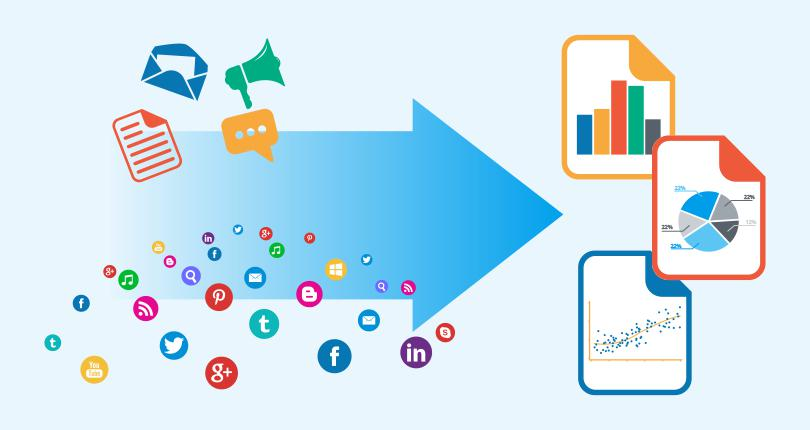

image from https://www.openpr.com/news/1201280/sentiment-analysis-software-market-global-industry-analysis-2018-popular-trends-technological-advancements-to-watch-out-for-near-future.html

**In this notebook, I tried three models,**
* Naive Bayes
* Random Forest Classifier
* LSTM

**to classify emotion from text.**

reference
* "A Study on Sentiment Analysis of Mental Illness Using Machine Learning Techniques" by Pradeep Kumar Tiwari, Muskan Sharma, Payal Garg, Tarun Jain, Vivek Kumar Verma and Afzal Hussain (https://iopscience.iop.org/article/10.1088/1757-899X/1099/1/012043/pdf),
* "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

# Importing

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mental-health-corpus/mental_health.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from scikitplot.metrics import plot_confusion_matrix, plot_roc

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import time
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, load_model
from keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

# Data Outline

**1) The first 5 lines in data**

In [3]:
data = pd.read_csv('../input/mental-health-corpus/mental_health.csv')
data.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


**2) Data shape**

In [4]:
print(data.shape)

(27977, 2)


**3) Null in data**

In [5]:
data.isnull().sum()

text     0
label    0
dtype: int64

**4) The number by labels**

In [6]:
data['label'].value_counts()

0    14139
1    13838
Name: label, dtype: int64

**5) Bar and Pie plot by '0' and '1'**

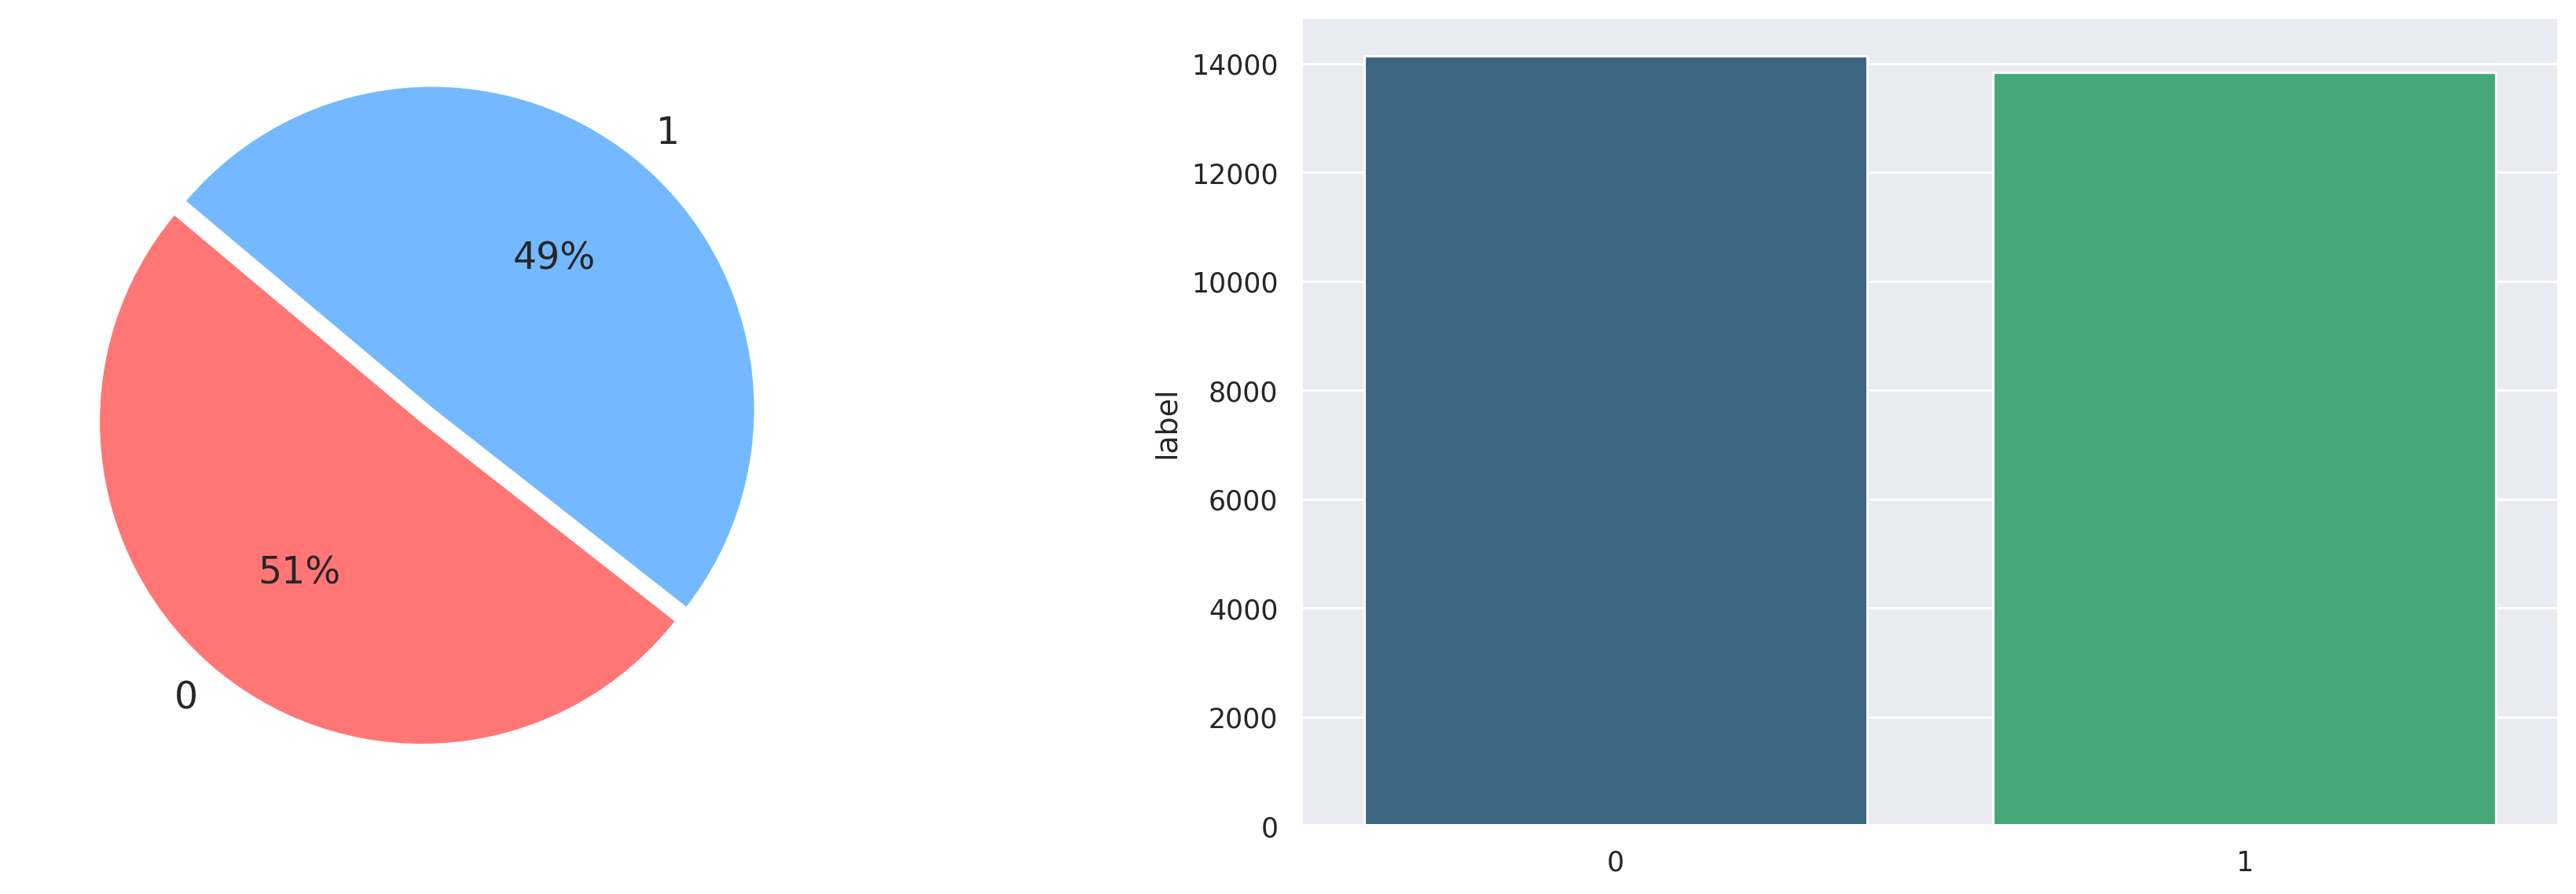

In [7]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

labels = [0, 1]
sizes = [14139, 13838]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 2)
sns.barplot(x = data['label'].unique(), y = data['label'].value_counts(), palette= 'viridis')

plt.show()

**6) Creating new columns 'Total Words' and 'Total Chars'**

In [8]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

data['Total Words'] = data['text'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["text"].apply(count_total_words)

In [9]:
data.head()

,text,label,Total Words,Total Chars
0,dear american teens question dutch person hear...,0,23,112
1,nothing look forward lifei dont many reasons k...,1,20,98
2,music recommendations im looking expand playli...,0,64,387
3,im done trying feel betterthe reason im still ...,1,100,493
4,worried year old girl subject domestic physic...,1,311,1819


**7) Kdeplot by Total Words**

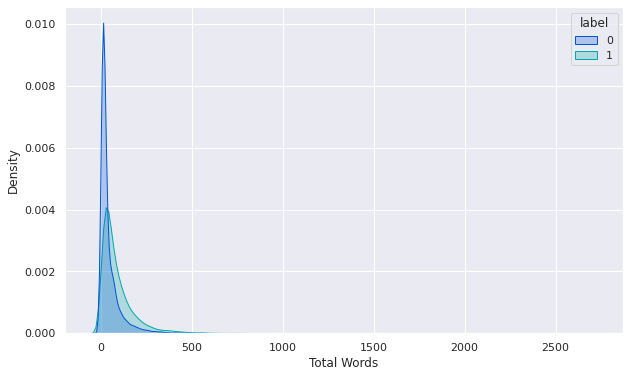

In [10]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

**8) Kdeplot by Total Chars**

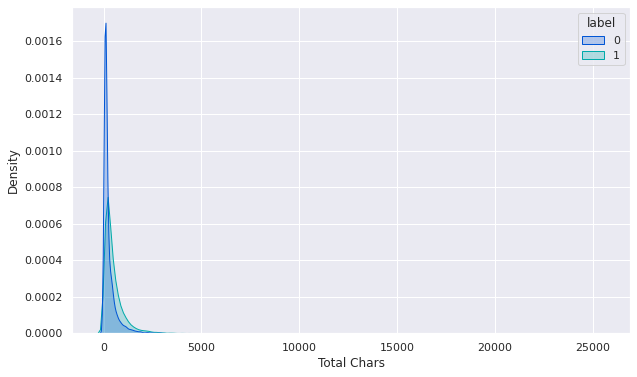

In [11]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

# Text preprocessing

**1) Lowercasing**

In [12]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

def convert_lowercase(text):
    text = text.lower()
    return text

data['text'] = data['text'].apply(convert_lowercase)

**2) Removing URLs**

In [13]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['text'] = data['text'].apply(remove_url)

**3) Removing Punctuations**

In [14]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['text'] = data['text'].apply(remove_punc)

**4) Removing stopwords**

In [15]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['text'] = data['text'].apply(remove_stopwords)

**5) Stemming**

In [16]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['text'] = data['text'].apply(perform_stemming)

**6) Creating new column 'Total Words After Transformation'**

In [17]:
data['Total Words After Transformation'] = data['text'].apply(lambda x: np.log(len(x.split())))

In [18]:
data.head()

,text,label,Total Words,Total Chars,Total Words After Transformation
0,dear american teen question dutch person heard...,0,23,112,3.135494
1,noth look forward lifei dont mani reason keep ...,1,20,98,2.944439
2,music recommend im look expand playlist usual ...,0,64,387,4.110874
3,im done tri feel betterth reason im still aliv...,1,100,493,4.574711
4,worri year old girl subject domest physicalmen...,1,311,1819,5.690359


# Data Visualization

**1) Word Cloud by label '0'**

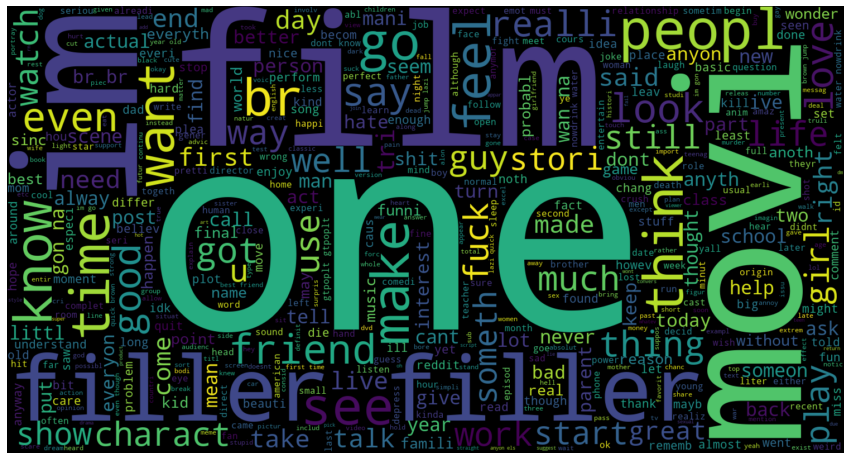

In [19]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

text = " ".join(data[data['label'] == 0]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**2) Word Cloud by label '1'**

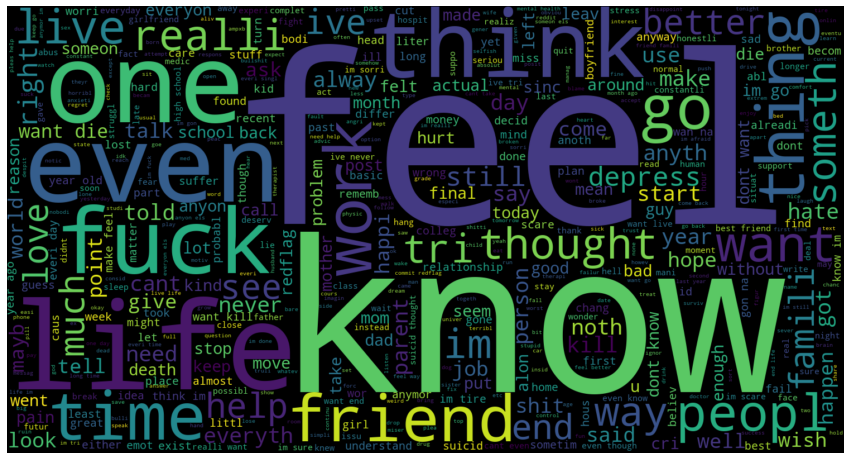

In [20]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

text = " ".join(data[data['label'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**3) Word Frequency by label '0'**

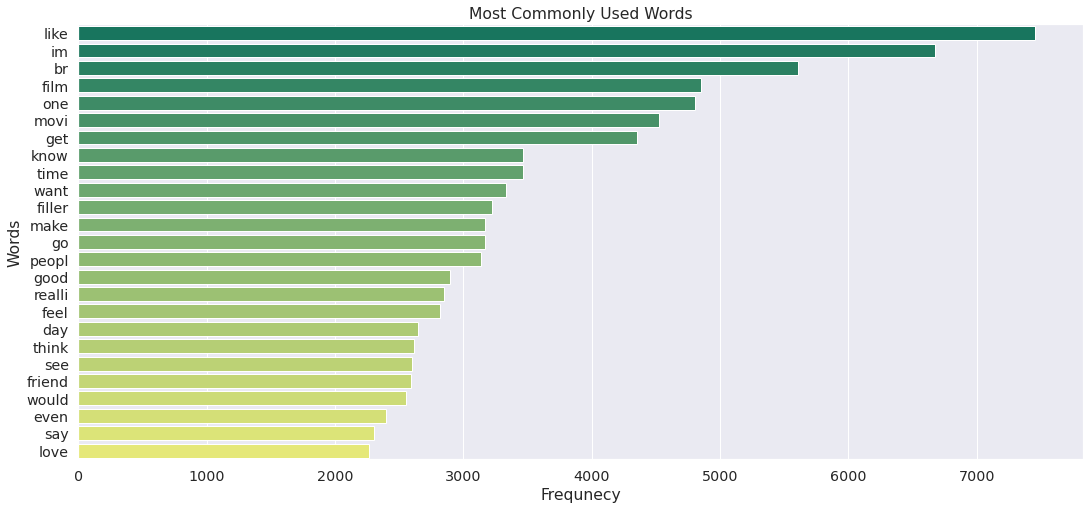

In [21]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

all_spam_words = []
for sentence in data[data['label'] == 0]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

**4) Word Frequency by label '1'**

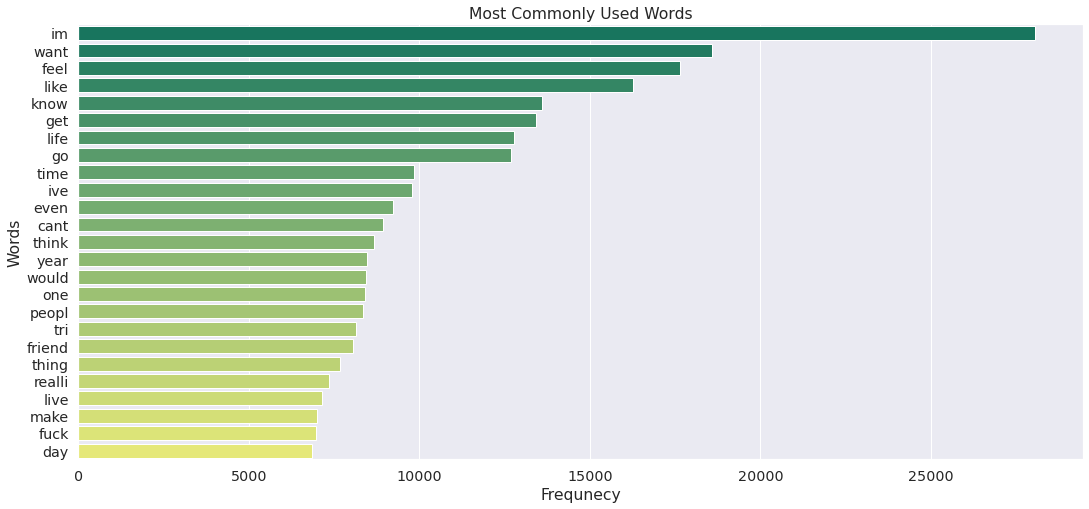

In [22]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

all_spam_words = []
for sentence in data[data['label'] == 1]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

# Modeling

**1) Naive Bayes**

In [23]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [24]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [25]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

Accuracy of the model: 0.888
Precision Score of the model: 0.839
Recall Score of the model: 0.957


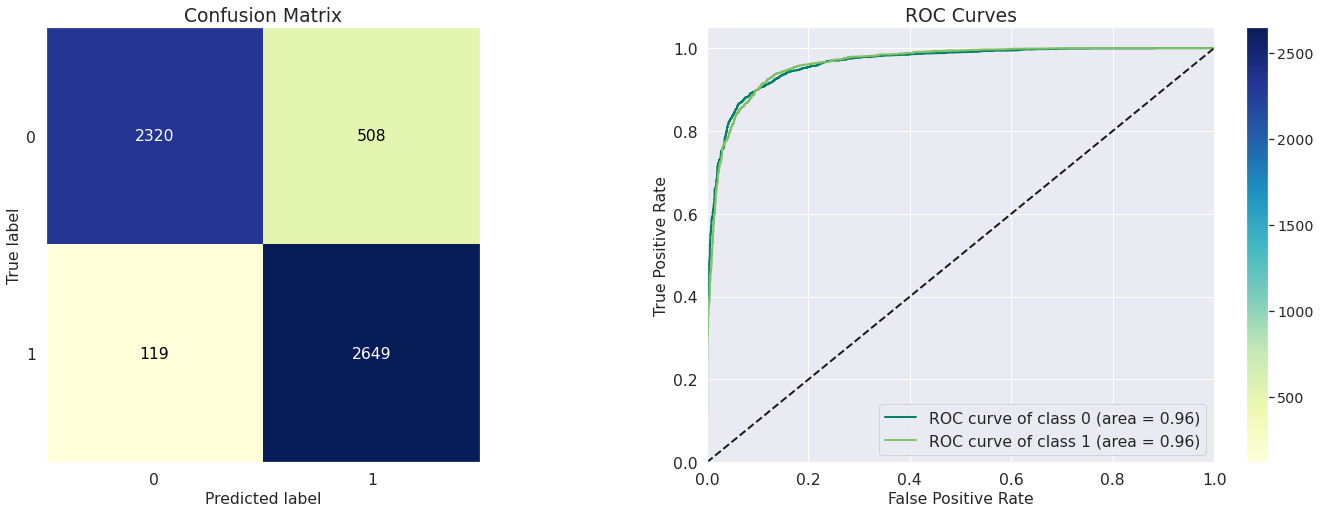

In [27]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

nb = MultinomialNB()
train_model(nb)

**2) Random Forest Classifier**

Accuracy of the model: 0.889
Precision Score of the model: 0.878
Recall Score of the model: 0.9


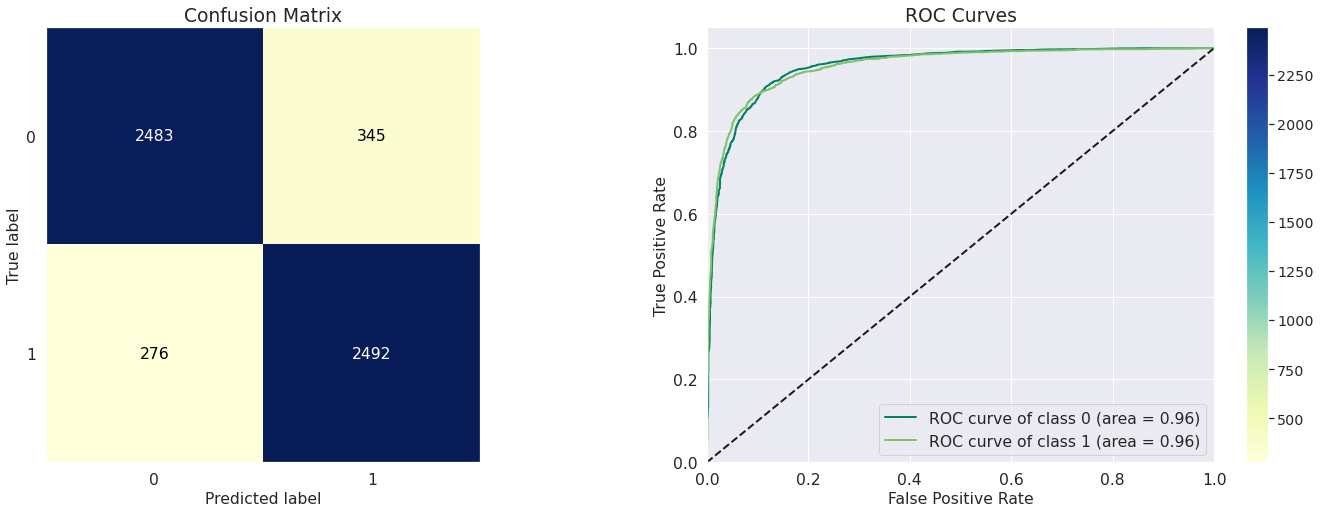

In [28]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)

**3) LSTM**

In [29]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [30]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', data['text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(data['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 dear american teen question dutch person heard guy get way easier thing learn age us sooooo thth grader like right guy learn math 

After Tokenization & Padding 
 [1890  719  805  288 4306   68  558  108    5   37  771   21  338  344
  158    2   71  108  338 1028    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [31]:
y = data.label
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (15666, 100) (15666,)
Validation Set: (6715, 100) (6715,)
Test Set:       (5596, 100) (5596,)


2023-02-03 06:36:58.706000: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


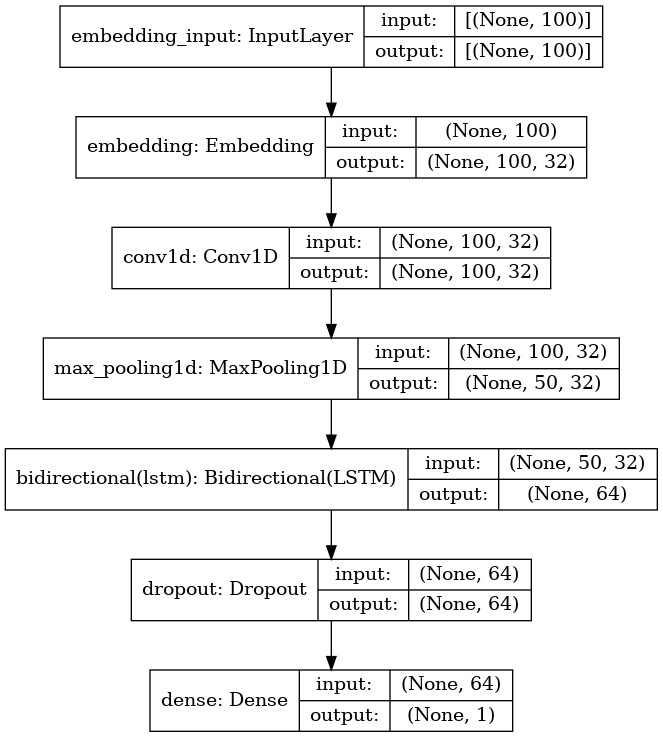

In [32]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

plot_model(model, show_shapes = True)

In [33]:
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=[tf.keras.metrics.Recall(),'accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 179,809
Trainable params: 179,809
Non-trainable params: 0
__________________________________________________

In [34]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50


2023-02-03 06:37:00.627553: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


245/245 [==============================] - 23s 81ms/step - loss: 0.6913 - recall: 0.1546 - accuracy: 0.5426 - val_loss: 0.6899 - val_recall: 0.2891 - val_accuracy: 0.5994
Epoch 2/50
245/245 [==============================] - 19s 80ms/step - loss: 0.6884 - recall: 0.2673 - accuracy: 0.5860 - val_loss: 0.6865 - val_recall: 0.3183 - val_accuracy: 0.6073
Epoch 3/50
245/245 [==============================] - 18s 75ms/step - loss: 0.6845 - recall: 0.3323 - accuracy: 0.6053 - val_loss: 0.6808 - val_recall: 0.3321 - val_accuracy: 0.6118
Epoch 4/50
245/245 [==============================] - 19s 79ms/step - loss: 0.6766 - recall: 0.3338 - accuracy: 0.6100 - val_loss: 0.6700 - val_recall: 0.3764 - val_accuracy: 0.6216
Epoch 5/50
245/245 [==============================] - 19s 78ms/step - loss: 0.6622 - recall: 0.3944 - accuracy: 0.6246 - val_loss: 0.6502 - val_recall: 0.4041 - val_accuracy: 0.6276
Epoch 6/50
245/245 [==============================] - 19s 78ms/step - loss: 0.6402 - recall: 0.4965 -

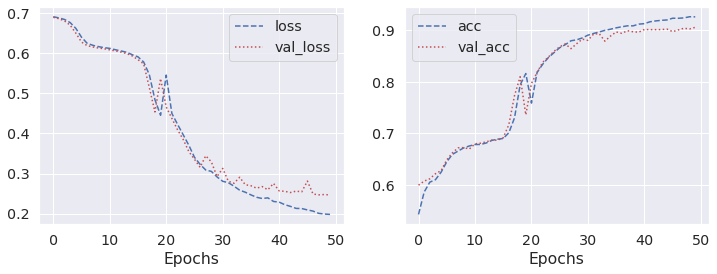

In [35]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [36]:
loss, accuracy,recall= model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))
print('Recall  : {:.4f}'.format(recall))

Accuracy  : 0.8941
Recall  : 0.9062
